In [47]:
import re
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

In [36]:
print("Current working directory:", Path.cwd())

root_dir = Path.cwd().parent
file_path = root_dir / "data" / "diabetes" / "diabetes-data" / "Diabetes-Data"
code_path = file_path / "Data-Codes"
data_path = file_path / "data-01"

Current working directory: /app/notebooks


In [40]:
with open(code_path, "r") as f:
    text = f.read()

# Extrai linhas com formato "code = description"
pattern = r"(\d+)\s*=\s*(.+)"
matches = re.findall(pattern, text)

# Converte para DataFrame
df_codes = pd.DataFrame(matches, columns=["code", "description"])
df_codes["code"] = df_codes["code"].astype(int)

# Visualização
df_codes

,code,description
0,33,Regular insulin dose
1,34,NPH insulin dose
2,35,UltraLente insulin dose
3,48,Unspecified blood glucose measurement
4,57,Unspecified blood glucose measurement
5,58,Pre-breakfast blood glucose measurement
6,59,Post-breakfast blood glucose measurement
7,60,Pre-lunch blood glucose measurement
8,61,Post-lunch blood glucose measurement
9,62,Pre-supper blood glucose measurement


In [51]:
df = pd.read_csv(
    data_path,
    sep="\t",
    header=None,
    names=["date", "time", "code", "value"],
    dtype={"date": str, "time": str, "code": int, "value": float}
)

# Concatena e transforma em datetime
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%m-%d-%Y %H:%M", errors="coerce")

# Remove colunas antigas
df.drop(columns=["date", "time"], inplace=True)

# Reorganiza colunas para manter datetime como primeira
df = df[["datetime", "code", "value"]]

# Adiciona os eventos descritivos
code_map = pd.Series(df_codes.description.values, index=df_codes.code).to_dict()
df["event"] = df["code"].map(code_map)

df.head(10)

,datetime,code,value,event
0,1991-04-21 09:09:00,58,100.0,Pre-breakfast blood glucose measurement
1,1991-04-21 09:09:00,33,9.0,Regular insulin dose
2,1991-04-21 09:09:00,34,13.0,NPH insulin dose
3,1991-04-21 17:08:00,62,119.0,Pre-supper blood glucose measurement
4,1991-04-21 17:08:00,33,7.0,Regular insulin dose
5,1991-04-21 22:51:00,48,123.0,Unspecified blood glucose measurement
6,1991-04-22 07:35:00,58,216.0,Pre-breakfast blood glucose measurement
7,1991-04-22 07:35:00,33,10.0,Regular insulin dose
8,1991-04-22 07:35:00,34,13.0,NPH insulin dose
9,1991-04-22 13:40:00,33,2.0,Regular insulin dose


In [52]:
df.dtypes

datetime    datetime64[ns]
code                 int64
value              float64
event               object
dtype: object

📊 1. Distribuição dos tipos de eventos

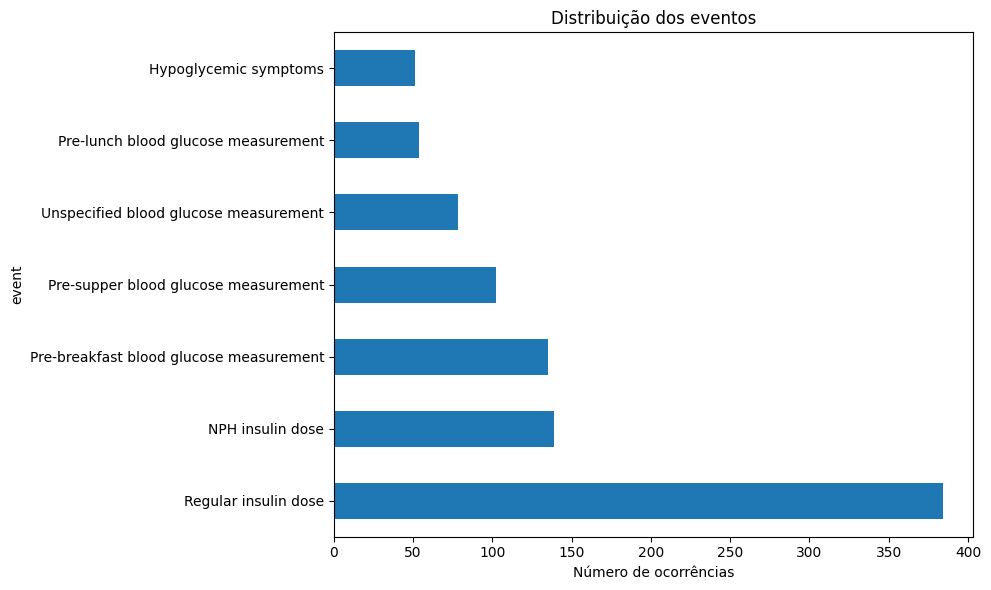

In [57]:
def plot_event_distribution(df):
    event_counts = df["event"].value_counts()
    event_counts.plot(kind="barh", figsize=(10, 6), title="Distribuição dos eventos")
    plt.xlabel("Número de ocorrências")
    plt.tight_layout()
    plt.show()
plot_event_distribution(df)

📈 2. Série temporal da glicose

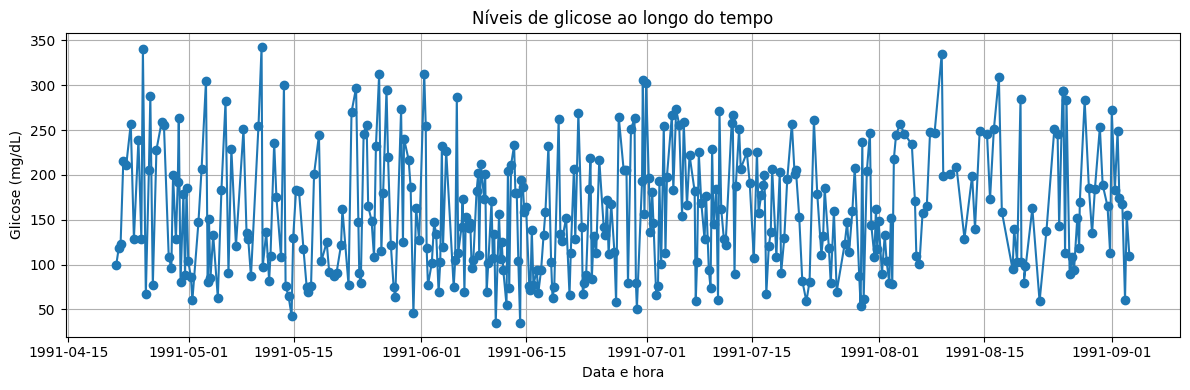

In [58]:
def plot_glucose_time_series(df):
    glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
    df_glucose = df[df["code"].isin(glucose_codes)]

    plt.figure(figsize=(12, 4))
    plt.plot(df_glucose["datetime"], df_glucose["value"], marker="o")
    plt.title("Níveis de glicose ao longo do tempo")
    plt.xlabel("Data e hora")
    plt.ylabel("Glicose (mg/dL)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_glucose_time_series(df)

📉 3. Distribuição dos valores de glicose

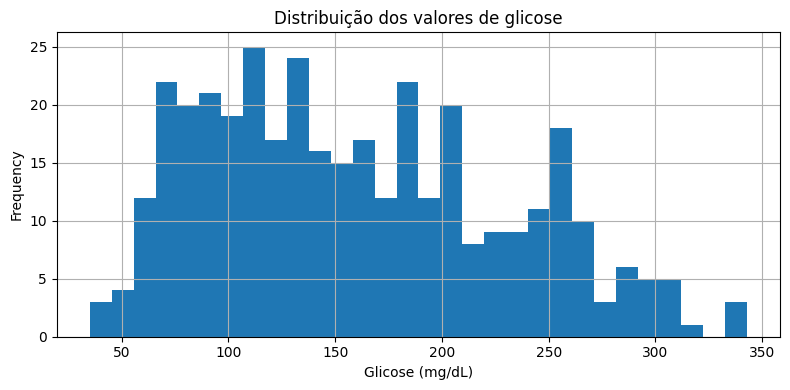

In [59]:
def plot_glucose_distribution(df):
    glucose_codes = [48, 57, 58, 59, 60, 61, 62, 63, 64]
    df_glucose = df[df["code"].isin(glucose_codes)]

    df_glucose["value"].plot.hist(
        bins=30,
        figsize=(8, 4),
        title="Distribuição dos valores de glicose"
    )
    plt.xlabel("Glicose (mg/dL)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_glucose_distribution(df)

📊 4. Eventos por dia

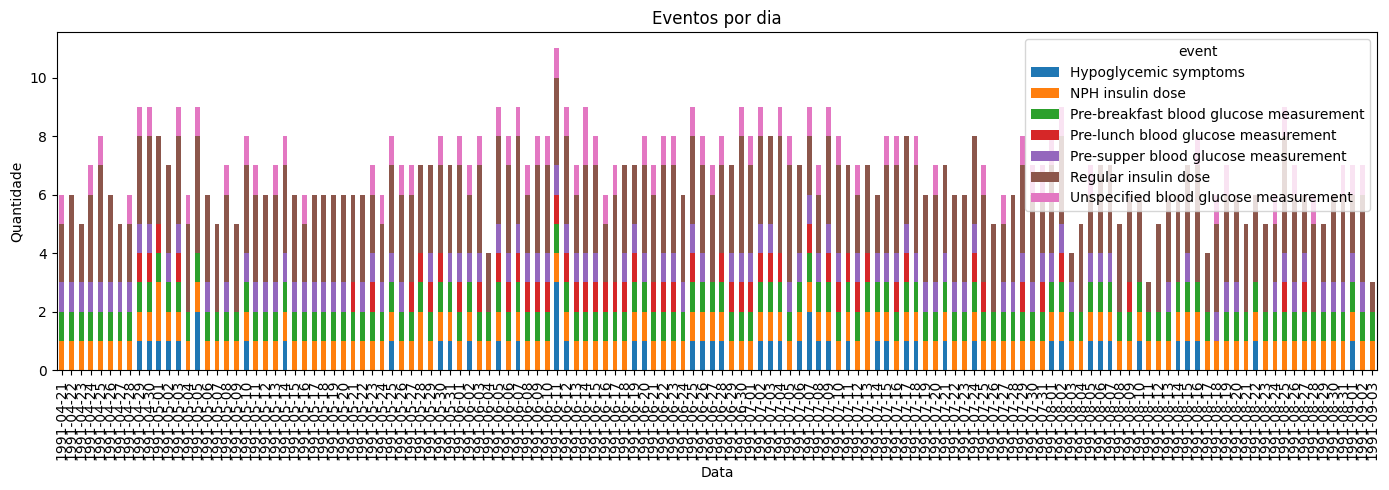

In [60]:
def plot_event_counts_per_day(df):
    df["date_only"] = df["datetime"].dt.date  # extrai apenas a data (sem hora)
    event_by_day = df.groupby(["date_only", "event"]).size().unstack().fillna(0)

    event_by_day.plot(kind="bar", stacked=True, figsize=(14, 5), title="Eventos por dia")
    plt.xlabel("Data")
    plt.ylabel("Quantidade")
    plt.tight_layout()
    plt.show()
plot_event_counts_per_day(df)